In [1]:
from keras.models import Sequential
from keras import layers
from keras.models import Sequential
from keras.layers import LSTM, Dense, Lambda, Dropout, GRU, TimeDistributed
from keras.optimizers import Adam, RMSprop
import numpy as np
from six.moves import range

Using TensorFlow backend.


# Parameters Config

In [2]:
class colors:
    ok = '\033[92m'
    fail = '\033[91m'
    close = '\033[0m'

In [3]:
TRAINING_SIZE = 80000
DIGITS = 3
REVERSE = False
MAXLEN = DIGITS + 1 + DIGITS
chars = '0123456789* '
RNN = layers.LSTM
HIDDEN_SIZE = 128
BATCH_SIZE = 128
LAYERS = 1

In [4]:
class CharacterTable(object):
    def __init__(self, chars):
        self.chars = sorted(set(chars))
        self.char_indices = dict((c, i) for i, c in enumerate(self.chars))
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars))
    
    # one-hot
    def encode(self, C, num_rows):
        # x is 2D...
        x = np.zeros((num_rows, len(self.chars)))
        for i, c in enumerate(C):
            x[i, self.char_indices[c]] = 1  # why showing True/False below ?
        return x
    
    def decode(self, x, calc_argmax=True):
        if calc_argmax:
            x = x.argmax(axis=-1)
        return "".join(self.indices_char[i] for i in x)

In [5]:
ctable = CharacterTable(chars)

In [6]:
ctable.indices_char

{0: ' ',
 1: '*',
 2: '0',
 3: '1',
 4: '2',
 5: '3',
 6: '4',
 7: '5',
 8: '6',
 9: '7',
 10: '8',
 11: '9'}

# Data Generation

In [7]:
# Generate the two lists, i.e. question and answer in p5 of the ppt

questions = []
expected = []
seen = set() #?

print('Generating data...')
while len(questions) < TRAINING_SIZE:
    
    # ?
    f = lambda: int(''.join(np.random.choice(list('0123456789')) for i in range(np.random.randint(1, DIGITS + 1))))
    a, b = f(), f()
    
    # avoid duplication
    key = tuple(sorted((a, b)))
    if key in seen:
        continue
    seen.add(key)
    
    q = '{}*{}'.format(a, b)
    query = q + ' ' * (MAXLEN - len(q))
    ans = str(a * b)
    ans += ' ' * (DIGITS + 3 - len(ans))
    
    # ?
    if REVERSE:
        query = query[::-1]
        
    questions.append(query)
    expected.append(ans)
    
print('Total addition questions:', len(questions))

Generating data...
Total addition questions: 80000


In [8]:
print(questions[:5], expected[:5])

['37*98  ', '9*36   ', '18*7   ', '5*4    ', '5*40   '] ['3626  ', '324   ', '126   ', '20    ', '200   ']


# Processing

In [9]:
print('Vectorization...')
x = np.zeros((len(questions), MAXLEN, len(chars)), dtype=np.bool)
y = np.zeros((len(expected), DIGITS + 3, len(chars)), dtype=np.bool)

for i, sentence in enumerate(questions):
    x[i] = ctable.encode(sentence, MAXLEN)
for i, sentence in enumerate(expected):
    y[i] = ctable.encode(sentence, DIGITS + 3)

Vectorization...


In [10]:
# shuffle the data
indices = np.arange(len(y))
np.random.shuffle(indices)
x = x[indices]
y = y[indices]

# train_test_split
# take the first 20000 element
train_x = x[:20000]
train_y = y[:20000]
# take the elements other than first 20000
test_x = x[20000:]
test_y = y[20000:]

# val set is about 1/10 of the train set
split_at = len(train_x) - len(train_x) // 10
(x_train, x_val) = train_x[:split_at], train_x[split_at:]
(y_train, y_val) = train_y[:split_at], train_y[split_at:]

print('Training Data:')
print(x_train.shape)
print(y_train.shape)

print('Validation Data:')
print(x_val.shape)
print(y_val.shape)

print('Testing Data:')
print(test_x.shape)
print(test_y.shape)

Training Data:
(18000, 7, 12)
(18000, 6, 12)
Validation Data:
(2000, 7, 12)
(2000, 6, 12)
Testing Data:
(60000, 7, 12)
(60000, 6, 12)


In [11]:
print("input: ", x_train[:1], '\n\n', "label: ", y_train[:1])

input:  [[[False False False False False False False False False False  True
   False]
  [False False False False False False False False  True False False
   False]
  [False False False False False False False False  True False False
   False]
  [False  True False False False False False False False False False
   False]
  [False False False  True False False False False False False False
   False]
  [False False False  True False False False False False False False
   False]
  [ True False False False False False False False False False False
   False]]] 

 label:  [[[False False False False False False False False False False False
    True]
  [False False False False False False False  True False False False
   False]
  [False False False False  True False False False False False False
   False]
  [False False False False False False False False  True False False
   False]
  [ True False False False False False False False False False False
   False]
  [ True False False False Fals

# Build Model

In [12]:
print('Build model...')

############################################
##### Build your own model here ############
############################################
model = Sequential()
model.add(LSTM(HIDDEN_SIZE, input_shape=(MAXLEN, len(chars))))
model.add(layers.RepeatVector(DIGITS + 3))
# model.add(Lambda(lambda x: x[:, -(DIGITS + 1):, :]))
model.add(LSTM(HIDDEN_SIZE, return_sequences=True))
model.add(TimeDistributed(Dense(len(chars), activation='softmax')))
optimizer = Adam()
model.compile(loss='categorical_crossentropy', optimizer=optimizer,
              metrics=['accuracy'])

model.summary()

Build model...
Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               72192     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 6, 128)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 6, 128)            131584    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 6, 12)             1548      
Total params: 205,324
Trainable params: 205,324
Non-trainable params: 0
_________________________________________________________________


In [13]:
loss = list()
val_loss = list()
val_ratio = list()
acc = list()

# Training

In [14]:
for iteration in range(100):
    print()
    print('-' * 50)
    print('Iteration', iteration)
    
    history = model.fit(x_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=1,
              validation_data=(x_val, y_val))
    loss.append(history.history['loss'][0])
    val_loss.append(history.history['val_loss'][0])
    acc.append(history.history['acc'][0])
    
    # test on 10 datapoint in the val. set (1 per iter.)
    correct_count = 0
    for i in range(10):
        ind = np.random.randint(0, len(x_val))
        rowx, rowy = x_val[np.array([ind])], y_val[np.array([ind])]
        
        preds = model.predict_classes(rowx, verbose=0)
        
        q = ctable.decode(rowx[0])
        correct = ctable.decode(rowy[0])
        guess = ctable.decode(preds[0], calc_argmax=False)
        
        # as ppt p7
        print('Q', q[::-1] if REVERSE else q, end=' ')
        print('T', correct, end=' ')
        if correct == guess:
            print(colors.ok + '☑' + colors.close, end=' ')
            correct_count += 1
        else:
            print(colors.fail + '☒' + colors.close, end=' ')
        print(guess)
    val_ratio.append(correct_count / 10)


--------------------------------------------------
Iteration 0
Instructions for updating:
Use tf.cast instead.
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 9s 526us/step - loss: 2.0150 - acc: 0.2693 - val_loss: 1.8733 - val_acc: 0.3065
Q 447*900 T 402300 ☒ 110000
Q 276*82  T 22632  ☒ 11460 
Q 645*385 T 248325 ☒ 115500
Q 979*360 T 352440 ☒ 111000
Q 964*78  T 75192  ☒ 11166 
Q 112*636 T 71232  ☒ 11166 
Q 90*924  T 83160  ☒ 11000 
Q 210*62  T 13020  ☒ 1100  
Q 62*402  T 24924  ☒ 11000 
Q 526*16  T 8416   ☒ 1140  

--------------------------------------------------
Iteration 1
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 6s 306us/step - loss: 1.8519 - acc: 0.3117 - val_loss: 1.8384 - val_acc: 0.3124
Q 240*380 T 91200  ☒ 120000
Q 803*77  T 61831  ☒ 11000 
Q 886*964 T 854104 ☒ 126644
Q 180*26  T 4680   ☒ 1200  
Q 431*125 T 53875  ☒ 11772 
Q 8*987   T 7896   ☒ 1242  
Q 36

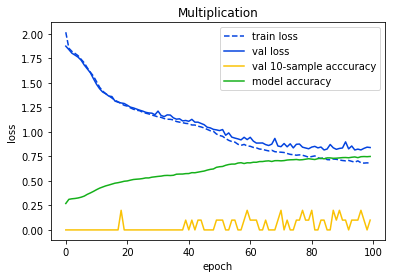

In [20]:
### plot loss and val_loss of each models together
import matplotlib.pyplot as plt

# loss_RMS_noDO = loss.copy()
# vl_RMS_noDO = val_loss.copy()
# vr_RMS_noDO = val_ratio.copy()

# plt.plot(loss_RV, color = 'tab:blue', linestyle='dashed')
# plt.plot(vl_RV, color = 'tab:blue')
# # plt.plot(vr_RV, color = 'tab:blue')

# plt.plot(loss_LBD, color = 'tab:red', linestyle='dashed')
# plt.plot(vl_LBD, color = 'tab:red')
# # plt.plot(vr_LBD, color = 'tab:red')

# plt.plot(loss_DO, color = 'tab:green', linestyle='dashed')
# plt.plot(vl_DO, color = 'tab:green')
# # plt.plot(vr_DO, color = 'tab:green')

# plt.plot(loss_RMS, color = 'xkcd:black', linestyle='dashed')
# plt.plot(vl_RMS, color = 'xkcd:black')
# # plt.plot(vr_RMS, color = 'xkcd:black')

# plt.plot(loss_RMS_noDO, color = 'xkcd:goldenrod', linestyle='dashed')
# plt.plot(vl_RMS_noDO, color = 'xkcd:goldenrod')
# # plt.plot(vr_RMS_noDO, color = 'xkcd:goldenrod')

# plt.legend(['RepeatValue_Adam', 'Lambda_Adam', 
#             'RepeatValue_Dropout_Adam', 'RepeatValue_Dropout_RMS',
#             'RepeatValue_Dropout_RMS'], color=['xkcd:black','xkcd:black','xkcd:black','xkcd:black','xkcd:black'], loc='upper right')

p1 = plt.plot(loss, color = 'xkcd:blue', linestyle='dashed')
p2 = plt.plot(val_loss, color = 'xkcd:blue')
p3 = plt.plot(val_ratio, color = 'xkcd:goldenrod')
p4 = plt.plot(acc, color = 'xkcd:green')
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("Multiplication")
plt.legend((p1[0], p2[0], p3[0], p4[0]),
           ('train loss', 'val loss', 'val 10-sample acccuracy', 'model accuracy'))
plt.savefig('multply.png')
plt.show()

# Testing

In [16]:
print("MSG : Prediction")
#####################################################
## Try to test and evaluate your model ##############
## ex. test_x = ["555+175", "860+7  ", "340+29 "]
## ex. test_y = ["730 ", "867 ", "369 "] 
#####################################################
model.evaluate(test_x, test_y)

MSG : Prediction
60000/60000 [==============================] - 9s 157us/step


[0.8514350372632344, 0.6739416665712993]

In [17]:
my_test_y = model.predict_classes(test_x)

correct_count = 0
for ind in range(test_y.shape[0]):
    rowy = test_y[np.array([ind])]

    preds = my_test_y[np.array([ind])]

    correct = ctable.decode(rowy[0])
    guess = ctable.decode(preds[0], calc_argmax=False)

    if correct == guess:
        correct_count += 1

print("test accuracy = ", correct_count / test_y.shape[0])

test accuracy =  0.08763333333333333
